# Algoritmos de similitud textual clásicos

- https://crucialbits.com/blog/a-comprehensive-list-of-similarity-search-algorithms/
  

## Leer archvio consoliado

In [2]:
import bibtexparser
import pandas as pd

# Configurar el parser
parser = bibtexparser.bparser.BibTexParser(common_strings=True)
parser.expect_multiple_parse = True  # Evita el warning

# Leer TODO el archivo de una vez
with open("consolidado.bib", encoding="utf-8") as f:
    bib_database = bibtexparser.load(f, parser=parser)

# Extraer la información
data = []
for entry in bib_database.entries:
    data.append({
        "title": entry.get("title", "").strip(),
        "authors": entry.get("author", ""),
        "keywords": entry.get("keywords", ""),
        "abstract": entry.get("abstract", "")
    })

df = pd.DataFrame(data)

# Eliminar duplicados por título
df_unique = df.drop_duplicates(subset="title", keep="first")
df_duplicates = df[df.duplicated(subset="title", keep=False)]

# Guardar resultados
df_unique.to_csv("articulos_unicos.csv", index=False)
df_duplicates.to_csv("articulos_repetidos.csv", index=False)

print(f"✅ Artículos totales: {len(df)}")
print(f"📘 Artículos únicos: {len(df_unique)}")
print(f"📄 Artículos repetidos: {len(df_duplicates)}")

df_unique.head()


✅ Artículos totales: 10226
📘 Artículos únicos: 10189
📄 Artículos repetidos: 38


,title,authors,keywords,abstract
0,Do Robots Dream of Passing a Programming Course?,"Torres, Nicolás",Training;Computational modeling;Instruments;Na...,Programming typically involves humans formulat...
1,WeAIR: Wearable Swarm Sensors for Air Quality ...,"Dimitri, Giovanna Maria and Parri, Lorenzo and...",Temperature measurement;Climate change;Cloud c...,The present study proposes the implementation ...
2,Discriminative-Generative Representation Learn...,"Li, Duanjiao and Chen, Yun and Zhang, Ying and...",Representation learning;Semantics;Asia;Self-su...,"Generative Adversarial Networks (GANs), as a f..."
3,3 Generative AI Models and LLM: Training Techn...,"Arun, C. and Karthick, S. and Selvakumara Samy...",,Generative artificial intelligence (AI) has be...
4,Virtual Human: A Comprehensive Survey on Acade...,"Cui, Lipeng and Liu, Jiarui",Digital humans;Motion capture;Face recognition...,As a creative method for virtual human individ...


## Selecion de articulso a comparar

In [3]:
# Ejemplo: selecionando los primeros 3
abstracts = df["abstract"].head(3).tolist()
titles = df["title"].head(3).tolist()

for i, t in enumerate(titles):
    print(f"{i}. {t}\n{abstracts[i][:200]}...\n")


0. Do Robots Dream of Passing a Programming Course?
Programming typically involves humans formulating instructions for a computer to execute computations. If we adhere to this definition, a machine would seemingly lack the capability to autonomously de...

1. WeAIR: Wearable Swarm Sensors for Air Quality Monitoring to Foster Citizens' Awareness of Climate Change
The present study proposes the implementation of an air quality measurement tool through the use of a swarm of wearable devices, named WeAIR, consisting of wearable sensors for measuring NOx, CO2, CO,...

2. Discriminative-Generative Representation Learning for One-Class Anomaly Detection
Generative Adversarial Networks (GANs), as a form of generative self-supervised learning, have garnered significant attention in anomaly detection. However, the generator's capacity for representation...



## Algoritmo de Levenshtein

In [4]:
import Levenshtein

def levenshtein_similarity(text1, text2):
    dist = Levenshtein.distance(text1, text2)
    max_len = max(len(text1), len(text2))
    similarity = 1 - dist / max_len
    
    # Interpretación del resultado
    if similarity >= 0.8:
        interpretation = "Los textos son muy similares."
    elif similarity >= 0.5:
        interpretation = "Los textos tienen cierta similitud moderada."
    elif similarity >= 0.2:
        interpretation = "Los textos son poco similares."
    else:
        interpretation = "Los textos no son similares."
    
    print(f"Similitud de Levenshtein: {similarity:.3f}")
    print(f"Interpretación: {interpretation}")
    return similarity


levenshtein_similarity(abstracts[0], abstracts[1])


Similitud de Levenshtein: 0.219
Interpretación: Los textos son poco similares.


0.21857923497267762

## Algoritmo de Similitud del Coseno con TF-IDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def interpretar_similitud(valor):
    """Interpreta el nivel de similitud según el valor de coseno."""
    if valor >= 0.8:
        return "Los textos son muy similares."
    elif valor >= 0.5:
        return "Los textos tienen similitud moderada."
    elif valor >= 0.2:
        return "Los textos son poco similares."
    else:
        return "Los textos no son similares."

# --- Cálculo del TF-IDF y similitud ---
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(abstracts)
cosine_sim = cosine_similarity(tfidf_matrix)

# --- Impresión de resultados ---
print("Matriz de similitud de coseno:")
print(cosine_sim)
print("\nInterpretación par a par:\n")

# Recorre cada par de textos (sin repetir)
for i in range(len(abstracts)):
    for j in range(i + 1, len(abstracts)):
        valor = cosine_sim[i][j]
        print(f"Similitud entre Abstract {i} y Abstract {j}: {valor:.3f} → {interpretar_similitud(valor)}")


Matriz de similitud de coseno:
[[1.         0.0429688  0.09021994]
 [0.0429688  1.         0.00515135]
 [0.09021994 0.00515135 1.        ]]

Interpretación par a par:

Similitud entre Abstract 0 y Abstract 1: 0.043 → Los textos no son similares.
Similitud entre Abstract 0 y Abstract 2: 0.090 → Los textos no son similares.
Similitud entre Abstract 1 y Abstract 2: 0.005 → Los textos no son similares.


## Algoritmo de Jaccard

In [6]:
def jaccard_similarity(a, b):
    # Convertir a conjuntos de palabras
    a_set, b_set = set(a.lower().split()), set(b.lower().split())
    similarity = len(a_set & b_set) / len(a_set | b_set)
    
    # Interpretación de la similitud
    if similarity >= 0.8:
        interpretation = "Los textos son muy similares."
    elif similarity >= 0.5:
        interpretation = "Los textos tienen similitud moderada."
    elif similarity >= 0.2:
        interpretation = "Los textos son poco similares."
    else:
        interpretation = "Los textos no son similares."
    
    # Mostrar resultados
    print(f"Similitud de Jaccard: {similarity:.3f}")
    print(f"Interpretación: {interpretation}")
    return similarity

# Ejemplo de uso
jaccard_similarity(abstracts[0], abstracts[1])


Similitud de Jaccard: 0.078
Interpretación: Los textos no son similares.


0.0782122905027933

## Algoritmo de Similitud Euclidiana

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances

# Vectorizar los textos (sin stopwords en inglés)
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(abstracts)

# Calcular distancias euclidianas
distances = euclidean_distances(X)

# Convertir a similitud (1 / (1 + distancia))
similarities = 1 / (1 + distances)

# Mostrar matriz de similitudes con interpretación
print("Matriz de similitud euclidiana:")
print(similarities)

# Interpretar los valores (solo pares distintos)
for i in range(len(abstracts)):
    for j in range(i + 1, len(abstracts)):
        sim = similarities[i, j]
        if sim >= 0.8:
            interpretation = "Los textos son muy similares."
        elif sim >= 0.5:
            interpretation = "Los textos tienen similitud moderada."
        elif sim >= 0.2:
            interpretation = "Los textos son poco similares."
        else:
            interpretation = "Los textos no son similares."
        
        print(f"\nSimilitud entre Abstract {i} y {j}: {sim:.3f}")
        print(f"Interpretación: {interpretation}")


Matriz de similitud euclidiana:
[[1.         0.06972692 0.06005113]
 [0.06972692 1.         0.05432747]
 [0.06005113 0.05432747 1.        ]]

Similitud entre Abstract 0 y 1: 0.070
Interpretación: Los textos no son similares.

Similitud entre Abstract 0 y 2: 0.060
Interpretación: Los textos no son similares.

Similitud entre Abstract 1 y 2: 0.054
Interpretación: Los textos no son similares.


# algoritmos de similitud basados en IA

## SBERT (Sentence-BERT) – Similitud semántica con embeddings

SBERT convierte cada texto en un vector numérico (embedding) en un espacio semántico.
Luego compara esos vectores usando la similitud del coseno:

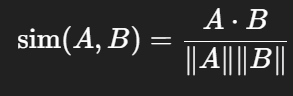
	​


Valores cercanos a 1 ⇒ textos muy similares.

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

In [8]:

from sentence_transformers import SentenceTransformer, util
import numpy as np

# --- Textos (abstracts) ---
texts = [abstracts[0], abstracts[1]]  # puedes cambiar a tus abstracts

# --- Cargar modelo SBERT ---
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- Obtener embeddings ---
embeddings = model.encode(texts, convert_to_tensor=True)

# --- Calcular similitud de coseno ---
similarity = util.cos_sim(embeddings[0], embeddings[1]).item()

# --- Interpretar el resultado ---
if similarity >= 0.8:
    interpretation = "Los textos son muy similares."
elif similarity >= 0.5:
    interpretation = "Los textos tienen similitud moderada."
elif similarity >= 0.2:
    interpretation = "Los textos son poco similares."
else:
    interpretation = "Los textos no son similares."

print(f"Similitud SBERT: {similarity:.3f}")
print(f"Interpretación: {interpretation}")


c:\Users\camil\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\camil\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not insta

Similitud SBERT: 0.189
Interpretación: Los textos no son similares.


## Cross-Encoder – Evaluación directa de pares de texto

El modelo recibe ambos textos juntos y predice una puntuación directa de similitud.
Se entrena para entender la relación entre oraciones, no solo las palabras.

Matemáticamente:

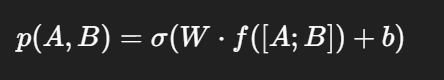


f([A;B]) es la representación conjunta del par dentro del transformer.

https://huggingface.co/cross-encoder/ms-marco-MiniLM-L6-v2

In [9]:
from sentence_transformers import CrossEncoder
import numpy as np

# --- Cargar modelo ---
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

# --- Evaluar similitud directa entre dos textos ---
pair = [[abstracts[0], abstracts[1]]]
score = cross_encoder.predict(pair)[0]

# --- Normalizar (si el score no está entre 0 y 1) ---
prob = 1 / (1 + np.exp(-score)) if score > 1 or score < 0 else score

# --- Interpretación ---
if prob >= 0.8:
    interpretation = "Los textos son muy similares."
elif prob >= 0.5:
    interpretation = "Los textos tienen similitud moderada."
elif prob >= 0.2:
    interpretation = "Los textos son poco similares."
else:
    interpretation = "Los textos no son similares."

print(f"Puntaje Cross-Encoder: {score:.3f}")
print(f"Probabilidad normalizada: {prob:.3f}")
print(f"Interpretación: {interpretation}")


c:\Users\camil\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\camil\.cache\huggingface\hub\models--cross-encoder--ms-marco-MiniLM-L-6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not install

Puntaje Cross-Encoder: -6.766
Probabilidad normalizada: 0.001
Interpretación: Los textos no son similares.
